In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from jury import Jury


/data/home/acw630/venvs/lam/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# llaqo_df = pd.read_csv("checkpoint_2274000.csv")
# llaqo_df = pd.read_csv("checkpoint_132000.csv")
# llaqo_df = pd.read_csv("ltu_results.csv")
llaqo_df = pd.read_csv("mullama_results.csv")
llaqo_df[-5:]

,audio_path,question,response,rating,gt,verbal_output,verbal_gt,question_id,question_category,mae
131,/data/EECS-MachineListeningLab/datasets/LLaQo/...,How would you rate the correctness of the rhyt...,The rhythm is correct.,NaN,6,"Yes, the piece is played with the correct rhythm.",I think it is as per the metronome.,9,rhythm and tempo,NaN
132,/data/EECS-MachineListeningLab/datasets/LLaQo/...,How would you rate the consistency of the temp...,The tempo is very consistent throughout the pi...,NaN,6,"No, the tempo is not kept constant.",Stable until the end.,10,rhythm and tempo,NaN
133,/data/EECS-MachineListeningLab/datasets/LLaQo/...,How would you rate the connectivity of the lin...,The connectivity of the lines is rated as 6 on...,6.0,6,"No, the lines are not connected.",It could be a little stronger or weaker.,11,articulation,0.0
134,/data/EECS-MachineListeningLab/datasets/LLaQo/...,How would you rate the sense of tonality? on a...,The sense of tonality is rated as poor.,NaN,4,"No, it is played with a sense of dissonance.",Ending could be a little more polite.,12,tone production,NaN
135,/data/EECS-MachineListeningLab/datasets/LLaQo/...,How would you rate the naturalness of the dyna...,The naturalness of the dynamics change is rate...,6.0,6,"Yes, the dynamics change is natural and not fo...",I think it plays in mf.,13,dynamics,0.0


In [5]:
llaqo_df['validity'] = llaqo_df['mae'].notna().astype(int)

precision_recall_fscore_support([1] * len(llaqo_df), llaqo_df['validity'], average='binary')


(1.0, 0.4852941176470588, 0.6534653465346535, None)

: 

In [3]:
def overview(df):

    # Step 1: Create a new column 'validity' where 1 indicates a valid numeric response and 0 indicates an invalid response
    df['validity'] = df['mae'].notna().astype(int)

    # Step 2: Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support([1] * len(df), df['validity'], average='binary')

    print(f"Precision: {precision}")

    print(f"mean absolute error: {df['mae'].mean()} +- {df['mae'].std()}" )

def plot_by_qidx(df):
    # Assuming the DataFrame is named df
    # You might need to convert 'question_id' to a string if it's not already, for better plotting
    df['question_id'] = df['question_id'].astype(str)

    # Setup the figure and axes
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))  # 2 rows, 1 column

    # First plot: Mean Absolute Error by Question ID
    sns.barplot(ax=ax[0], x='question_id', y='mae', hue='question_id', data=df, estimator=np.average, palette='coolwarm')
    ax[0].set_title('Mean Absolute Error by Question ID')
    ax[0].set_xlabel('Question ID')
    ax[0].set_ylabel('Mean Absolute Error')
    ax[0].tick_params(axis='x', rotation=45)  # Rotate for better readability

    # Second plot: Mean Absolute Error by Question Category
    sns.barplot(ax=ax[1], x='question_category', y='mae',  hue='question_category', data=df, estimator=np.average, palette='viridis')
    ax[1].set_title('Mean Absolute Error by Question Category')
    ax[1].set_xlabel('Question Category')
    ax[1].set_ylabel('Mean Absolute Error')
    ax[1].tick_params(axis='x', rotation=45)  # Rotate for better readability

    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()

Precision: 1.0
mean absolute error: 1.7740112994350283 +- 1.1893477298918387
mean absolute error: 1.7740112994350283 +- 1.1893477298918387


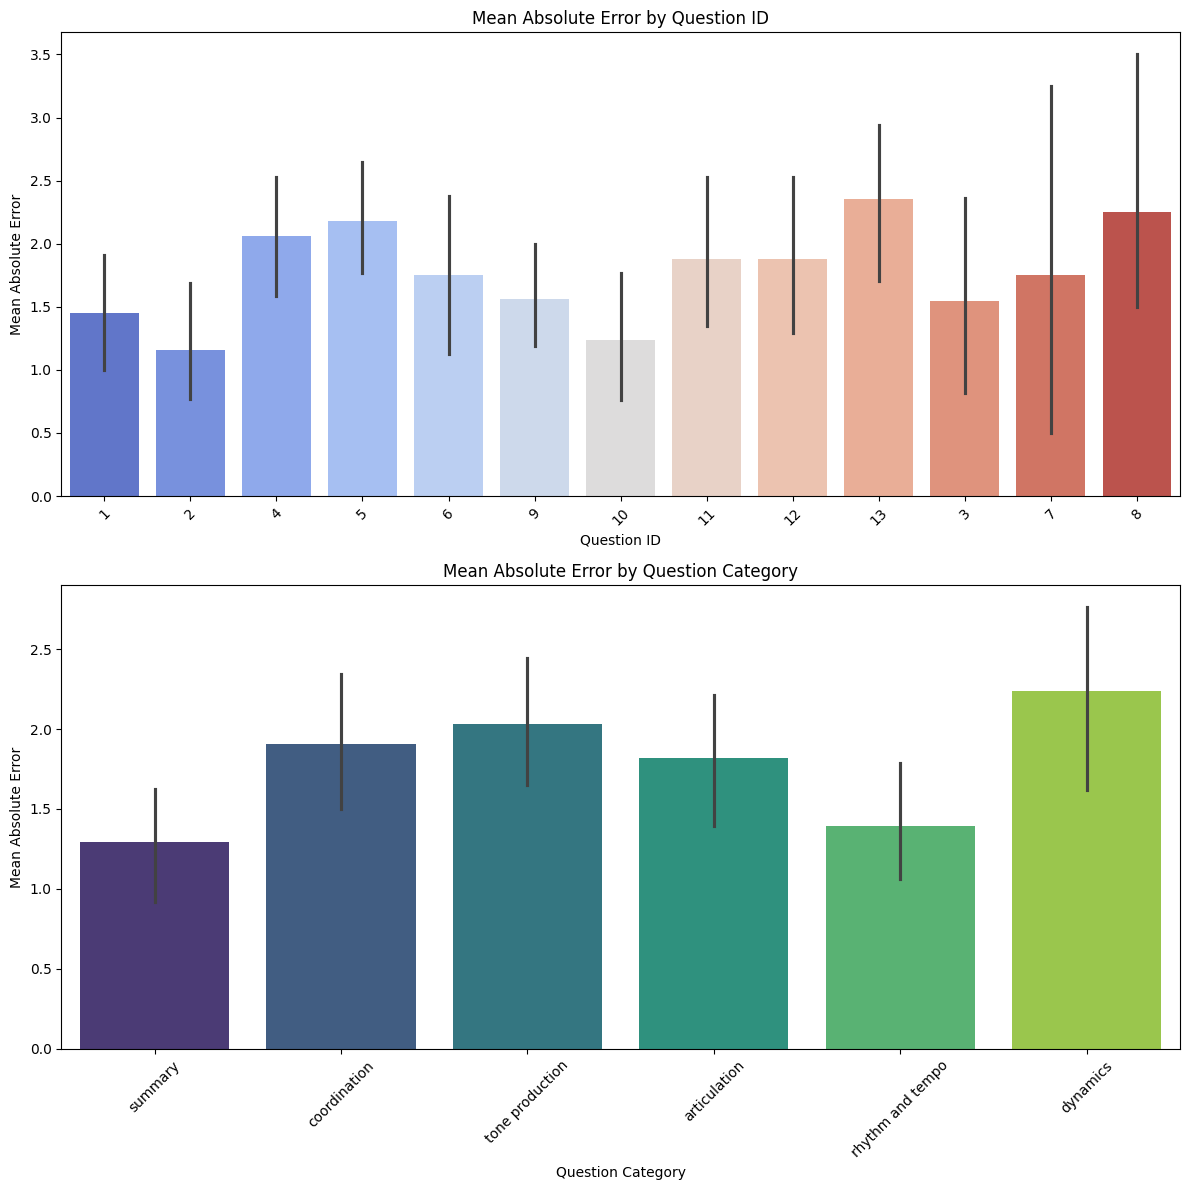

In [7]:
overview(llaqo_df)
plot_by_qidx(llaqo_df)

In [6]:
scorer = Jury()
# scorer = Jury(metrics=['bertscore'])

# predictions = [s[2:-2] for s in llaqo_df['verbal_output'].tolist()]
predictions = llaqo_df['verbal_output'].tolist()
references = llaqo_df['verbal_gt'].tolist()
scores = scorer(predictions=predictions, references=references)
scores

{'total_items': 187,
 'empty_items': 0,
 'bleu_1': {'score': 0.17094017094017097,
  'precisions': [0.17094017094017094],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0022844089091947,
  'translation_length': 3510,
  'reference_length': 3502},
 'bleu_2': {'score': 0.07522344846750649,
  'precisions': [0.17094017094017094, 0.033102618116160096],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0022844089091947,
  'translation_length': 3510,
  'reference_length': 3502},
 'bleu_3': {'score': 0.03358793000749121,
  'precisions': [0.17094017094017094,
   0.033102618116160096,
   0.006696428571428571],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0022844089091947,
  'translation_length': 3510,
  'reference_length': 3502},
 'bleu_4': {'score': 0.012661239833162507,
  'precisions': [0.17094017094017094,
   0.033102618116160096,
   0.006696428571428571,
   0.0006781959986436081],
  'brevity_penalty': 1.0,
  'length_ratio': 1.0022844089091947,
  'translation_length': 3510,
  'reference_length': 35

## GT analysis

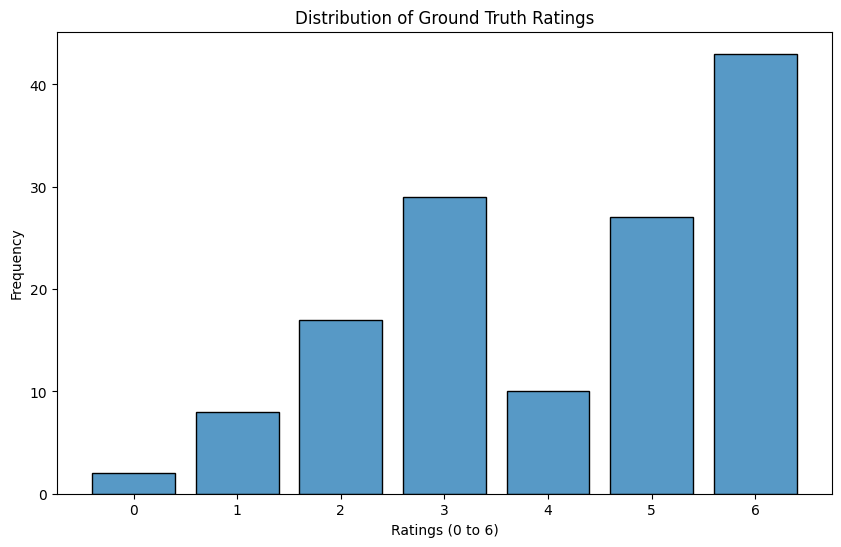

In [16]:

plt.figure(figsize=(10, 6))
sns.histplot(data=llaqo_df, x='gt', bins=range(8), kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.title('Distribution of Ground Truth Ratings')
plt.xlabel('Ratings (0 to 6)')
plt.ylabel('Frequency')
plt.xticks(range(7))  # Ensure we have ticks for each rating from 0 to 6
plt.show()

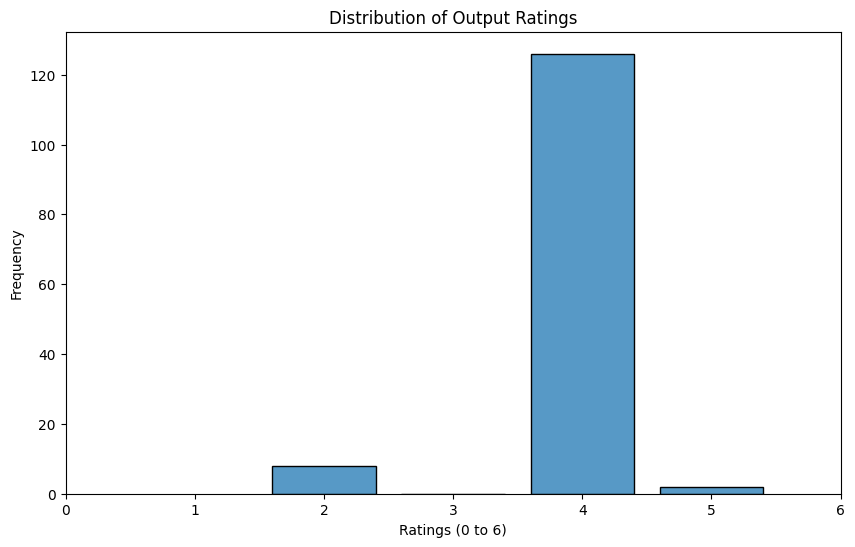

In [22]:

plt.figure(figsize=(10, 6))
sns.histplot(data=llaqo_df, x='output_rating',  bins=range(8), kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.title('Distribution of Output Ratings')
plt.xlabel('Ratings (0 to 6)')
plt.ylabel('Frequency')
plt.xticks(range(7))  # Ensure we have ticks for each rating from 0 to 6
plt.show()

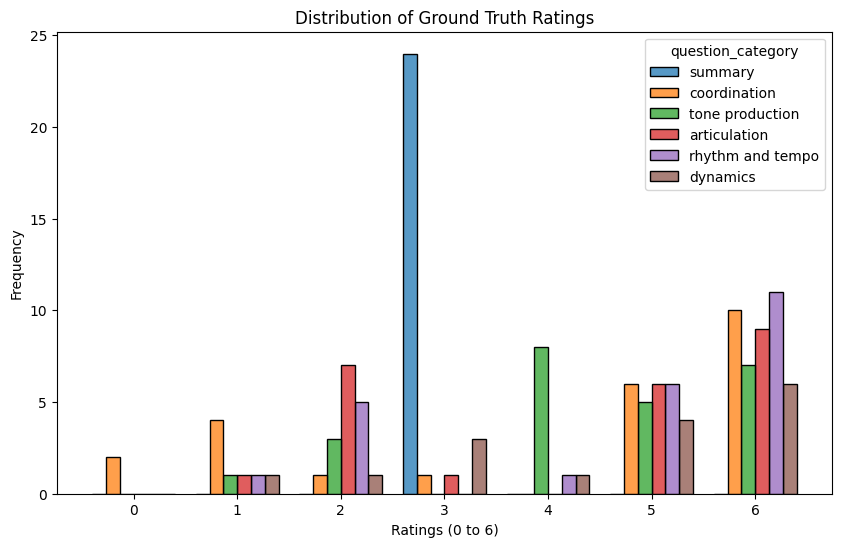

In [10]:

plt.figure(figsize=(10, 6))
sns.histplot(data=llaqo_df, x='gt', hue='question_category', bins=range(8), kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.title('Distribution of Ground Truth Ratings')
plt.xlabel('Ratings (0 to 6)')
plt.ylabel('Frequency')
plt.xticks(range(7))  # Ensure we have ticks for each rating from 0 to 6
plt.show()